## Take a bunch of runs and re-do them with 

In [8]:
from matplotlib import rc
import numpy as np
from netCDF4 import Dataset
import matplotlib.pyplot as plt
import os
import xarray as xr
import subprocess
import matplotlib.pyplot as plt
import shutil
os.chdir("/home/149/ab8992/bottom_near_inertial_waves/automate_experiments")

import autolib as al
from dask.distributed import Client
client = Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 4
Total threads: 8,Total memory: 32.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:44273,Workers: 4
Dashboard: /proxy/8787/status,Total threads: 8
Started: Just now,Total memory: 32.00 GiB
Comm: tcp://127.0.0.1:37765,Total threads: 2
Dashboard: /proxy/40129/status,Memory: 8.00 GiB
Nanny: tcp://127.0.0.1:43427,


# Notebook to re-run our experiments in June. 

Want to create a master notebook that generates all of the common forcings, and the perterbation values for each experiment. Write a function that takes common & perterbation fields

| Experiment | Common | Perterbed|
| --- |---|--- |
| Topo Height | windstress | topog |
| Topo Width | Windstress | topog  |
| Forcing Width | topog | Windstress  |
| Strat | Windstress | topog|
| Duration | topog | Windstress |
| Strength | topog | Windstress |

Experiment name format:

| Type | Format |
|---|---|
| experiments | `june_perterb_hill_nlayer` |
|common topog  | `june_common_hill_nlayer`  |
|common wind | `june_common_wind_nlayer`  |


In [9]:
### COMMON ACROSS ALL EXPERIMENTS. 
##########################################################
nlayers = 2             # number of layers
Lx = 4000                # domain zonal extent [km]
Ly = 1000                # domain meridional extent [km]
H  = 4000                # total fluid's depth in [m]
gridspacing = 2          # in [km]
flat = False
reverse = True
x = np.arange(0, Lx, gridspacing)
y = np.arange(-Ly/2, Ly/2, gridspacing)
ninterf = nlayers + 1    # number of interfaces
interfaces = np.arange(0,  ninterf)
nx = int(round(Lx/gridspacing))
ny = int(round(Ly/gridspacing))
overrides = ["ADIABATIC = True",
             "RHO_0 = 1027.0",
             f"NJGLOBAL={ny}",
             f"NIGLOBAL={nx}",
             f"LENLON = {Lx}.0",
             f"WESTLON = -{Lx//2}.0",
             f"LENLAT = {Ly}.0",
             f"WESTLAT = -{Ly//2}.0"]
default_dir = "default_rundir"


## Default values when unperturbed
default_height = 500 # m
default_forcing_latwidth = 300 # km
default_duration = 5 # hours
default_layerdensities = np.linspace(1027,1029,nlayers) ## This is the default stratification
default_strength = 1
default_ridge_width = 12.5 # km


## Value s from first pass! 
## Perterbation values
## strat variables 
strats = [0.25,0.2,0.5,0.75,1,1.5,2,3,4,0.001,0.01,6]

## Height
heights = [10,20,50,80,120,150,225,275,350,450,600,750,1000,1250,1500,2000]

## Duration
durations = [0.5,1,2,3,4,5,6,8.7,10] ## Note! Will need to modify the amount of time that model runs for with forcing in this case

## Strength
strengths = [0.1,0.2,0.5,0.75,1,1.25,1.5,2,3,4,10]

## Topog Width
widths = [4,8,12.5,16,25,35,50,100,200] 

## Forcing Width
forcing_widths = [25,50,75,100,150,175,200,300,500,800,1000]


## New values to fill in gaps

durations = [7,8,12,14,15,16,20]
heights = [500,650,700]
strengths = [5,6,7,8,9]
forcing_widths = [250,400]
widths = [75,125,150,300,400,500,600,700,800,1000]
strats = [1.25]

## Make common forcing

In [22]:
from importlib import reload
reload(al)
STRESS_X = al.windstress_gaussian(nx = nx,
                                           ny = ny,
                                           duration=default_duration,
                                           strength=default_strength,
                                           forcing_latwidth = default_forcing_latwidth,
                                           reverse = True)

for nlayers in [2,5,10]:
    eta_ridge = al.eta_gaussian_hill(
        nlayers=nlayers,
        ridge=True,
        nx = nx,
        ny = ny,
        height = default_height
        )
    eta_hill = al.eta_gaussian_hill(
        nlayers=nlayers,
        ridge=False,
        nx = nx,
        ny = ny,
        height = default_height
        )
    ## Save default topo for different layers and topo types
    al.save_topo(x,
                 y,
                 None,
                 None,
                 eta_hill,
                 f"/juneruns/common/june_common_hill_{nlayers}layers",
                 savewind = False)
    
    al.save_topo(x,
                 y,
                 None,
                 None,
                 eta_ridge,
                 f"/juneruns/common/june_common_ridge_{nlayers}layers",
                 savewind = False)

## Save the common wind forcing
al.save_topo(x,y,STRESS_X,STRESS_X * 0,eta_hill,f"/juneruns/common/june_common_wind",savedensities = False)

## Making each set of forcing files

| Experiment | Method|
| --- |---|
| Topo Height | Open default and multiply
| Topo Width | Remake
| Forcing Width | Remake
| Strat | Remake
| Duration | Remake 
| Strength | Open default and multiply

In [10]:
## Iterate over topog type and nlayers
from importlib import reload
# reload(al)

def set_si_coords(array):
    return array.assign_coords({"time":("time",array.time.values * 60),
                             "xq":("xq",array.xq.values * 1000),
                             "xh":("xh",array.xh.values * 1000),
                             "yh":("yh",array.yh.values * 1000),
                             "yq":("yq",array.yq.values * 1000)
    })



class expt:
    def __init__(self,x,y,nlayers,variable,var_value,topo,common):
        self.nlayers = nlayers
        self.variable = variable
        self.var_value = var_value
        self.topo = topo
        self.common = common
        self.x = x
        self.y = y
        self.runname = f"june_{self.variable}_{self.topo}_{self.nlayers}layer_{self.variable}-{self.var_value}"
        self.exptname = f"june_{self.variable}_{self.topo}_{self.nlayers}layer"

        if not os.path.exists(f"/home/149/ab8992/bottom_near_inertial_waves/juneruns/{self.exptname}/{self.runname}"):
            os.makedirs(f"/home/149/ab8992/bottom_near_inertial_waves/juneruns/{self.exptname}/{self.runname}")

        subprocess.run(f"ln -s /g/data/v45/ab8992/mom6_channel_configs/juneruns/{self.exptname}/{self.runname} /home/149/ab8992/bottom_near_inertial_waves/juneruns/{self.exptname}/{self.runname}/inputdir",shell=True)
    
    def make_topo(self):
        if self.common == "windforcing":
            ## Make topog file
            ridge = self.topo == "ridge"
            eta = al.eta_gaussian_hill(
                nlayers=self.nlayers,
                ridge=ridge,
                nx = len(self.x),
                ny = len(self.y),
                **{self.variable : self.var_value}
                )

            al.save_topo(self.x,
                 self.y,
                 None,
                 None,
                 eta,
                 f"/juneruns/{self.exptname}/{self.runname}",
                 savewind = False,
                 **{self.variable : self.var_value}
                 )
        elif self.common == "topog":
            ## Make and save wind stress
            STRESS_X = al.windstress_gaussian(nx = len(self.x),
                                           ny = len(self.y),
                                           reverse = True,
                                           **{self.variable : self.var_value})
            al.save_topo(self.x,
                self.y,
                STRESS_X,
                STRESS_X * 0,
                np.zeros((1,len(self.y),len(self.x))),
                f"/juneruns/{self.exptname}/{self.runname}",
                savedensities = False
                )
        return
    
    def setup(self,overrides = None,walltime = None,default_dir = None,run_duration = 10,forcing_path=None):
        print("SETUP: " + self.runname)


        # june_common_ridge_{nlayers}layers
        if forcing_path == None:
            forcing_path = f"juneruns/{self.exptname}/{self.runname}" 

        if self.common == "topog":
            common_forcing_path = f"june_common_{self.topo}_{self.nlayers}layers"
        elif self.common == "windforcing":
            common_forcing_path = f"june_common_wind"
        al.setup_mom6(f"juneruns/{self.exptname}/{self.runname}",
                    forcing_path,
                    walltime = walltime,
                    overrides = overrides + [f"NK={self.nlayers}"],
                    common_forcing = f"juneruns/common/{common_forcing_path}",
                    default_dir=default_dir,
                    run_duration = run_duration
                    )   

    def run(self):
        print("RUNNING: " + self.runname)
        al.run_mom6(f"{self.exptname}/{self.runname}")   
        return
    def set_noforcing(self):
        subprocess.run(
            "/home/149/ab8992/bottom_near_inertial_waves/automated/forcing_off.sh",
            cwd = f"/home/149/ab8992/bottom_near_inertial_waves/juneruns/{self.exptname}/{self.runname}")        
        return
    def fastrun(self):
        subprocess.run(
            "payu run -f",shell= True,cwd = f"/home/149/ab8992/bottom_near_inertial_waves/juneruns/{self.exptname}/{self.runname}"
        )
        return


    def process_output(self,xrange = [-100,100], yrange = [-1510,-1490],tlim = None,outpath = None,integrate = True):
        """
        Copy of the baroclinic EF function in autolib. This time just return the fluxes along the boundaries of provided domain rather than 
        calculate huge array of EF
        """
        datapath = f"/home/149/ab8992/bottom_near_inertial_waves/juneruns/{self.exptname}/{self.runname}"

        e = xr.open_mfdataset(datapath +  "/archive/output00*/e_10min.nc",decode_times = False,parallel = True,chunks = {"zl":1,"time":50}).sel(
            xh = slice(xrange[0],xrange[1]),yh = slice(yrange[0],yrange[1])).isel(
                time = slice(0,tlim)
            )
        u = xr.open_mfdataset(datapath +  "/archive/output00*/u_10min.nc",decode_times = False,parallel = True,chunks = {"zl":1,"time":50}).sel(
            xq = slice(xrange[0],xrange[1]),yh = slice(yrange[0],yrange[1])).isel(
                time = slice(0,tlim)
            )
        # v = xr.open_mfdataset(datapath +  "/archive/output00*/v_10min.nc").sel(
        #     xh = slice(xrange[0],xrange[1]),yh = slice(yrange[0],yrange[1])).isel(
        #         time = slice(0,tlim)
        #     )
        tau = xr.open_mfdataset(datapath +  "/archive/output00*/taux_10min.nc",decode_times = False,parallel = True,chunks = {"time":50}).sel(
            xq = slice(xrange[0],xrange[1]),yh = slice(yrange[0],yrange[1])).isel(
                time = slice(0,tlim)
            )

        # v = data.v.interp(yq = data.u.yh).drop("yq").sel(xh = slice(xrange[0],xrange[1]),yh = slice(yrange[0],yrange[1]))
        e = e.e.assign_coords({"time":("time",e.time.values * 60),
                                "xh":("xh",e.xh.values * 1000),
                                "yh":("yh",e.yh.values * 1000)
            }).astype(float)
        tau = tau.taux.assign_coords({"time":("time",tau.time.values * 60),
                                "xq":("xq",tau.xq.values * 1000),
                                "yh":("yh",tau.yh.values * 1000)
            }).interp(xq = e.xh).drop("xq").astype(float)
        u = u.u.assign_coords({"time":("time",u.time.values * 60),
                                "xq":("xq",u.xq.values * 1000),
                                "yh":("yh",u.yh.values * 1000)
            }).interp(xq = e.xh).drop("xq").astype(float)


        # e = (e).persist()
        u = u.persist()
        # tau = tau.persist()

        # densities = u.zl.load()
        # thickness = al.get_thickness(e,densities)
        # u_dwa = al.dwa(thickness,u)
        # # v_dwa = dwa(thickness,v)
        # Mg = al.montgomery(e,densities)
        # Mgprime = Mg - al.dwa(thickness,Mg)

        # uprime = u - u_dwa
        # vprime = v - v_dwa

        # conv = (1027 * Mgprime.differentiate("xh") * thickness * u_dwa).sum("zl")

        wind_work = (tau * u.isel(zl = 0)).isel(
            time = slice(0,500),
            ).sel(xh = slice(-25000,25000)).integrate("xh").integrate("yh")

        # EF_zonal = (1027 * Mgprime * uprime * thickness).sum("zl").isel(xh = [0,-1]).rename({"xh":"xi"}).integrate("yh")
        # EF_merid = (1027 * Mgprime * vprime * thickness).sum("zl").isel(yh = [0,-1]).rename({"yh":"yi"})

        wind_work = wind_work.integrate("time")
        data = xr.Dataset(
            data_vars = {
                        # "EF_zonal":EF_zonal,
                        "wind_work":wind_work
                        # "u":u,
                        # "e":e,
                        # "thickness":thickness,## Comment these out to return to what I originally output
                        # "Mgprime":Mgprime, 
                        # "uprime":uprime
                        }
        )
        data.wind_work.attrs["units"] = "Integrated over meridional extent and 50km zonally"
        
        data.to_netcdf(f"/g/data/v45/ab8992/bottom_iwbs/juneresults/{self.runname}")
        return data
    


In [ ]:
## Test here    
# height1 = expt(x,y,2,"height",100,"ridge","windforcing")
# height1.make_topo()
# height1.setup(default_dir=default_dir,overrides=overrides)

# strat1 = expt(x,y,5,"strat",2,"hill","windforcing")
# strat1.make_topo()
# strat1.setup(default_dir=default_dir,overrides=overrides)

# dur = expt(x,y,5,"duration",10,"hill","topog")
# # dur.make_topo()
# dur.setup(default_dir=default_dir,overrides=overrides,run_duration=20)

# width = expt(x,y,5,"width",1000,"ridge","windforcing")
# width.make_topo()
# width.setup(default_dir=default_dir,overrides=overrides)

# forcing_width = expt(x,y,2,"forcing_latwidth",1000,"ridge","topog")
# forcing_width.make_topo()
# forcing_width.setup(default_dir=default_dir,overrides=overrides)
# 
# strength = expt(x,y,5,"strength",1000,"ridge","topog")
# strength.make_topo()
# strength.setup(default_dir=default_dir,overrides=overrides)
# strength.run()

TypeError: __init__() got an unexpected keyword argument 'chunks'

## Make the inputs for each experiment

In [ ]:
import numpy as np
T = 2 * np.pi / 1e-4
T_hrs = T / 3600
T_hrs

17.453292519943293

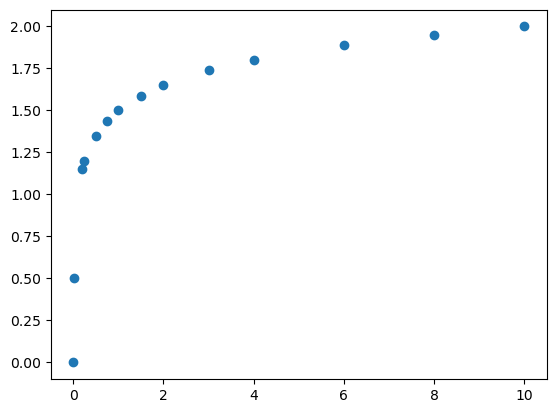

In [ ]:
import matplotlib.pyplot as plt
def N(strat):
    return np.sqrt(1e-2 * 1e-3 * strat)

f = 1e-4

N(np.array(strats))

plt.scatter(np.array(strats),np.log10(N(np.array(strats))/f))


In [21]:
default_dir

'default_rundir'

In [14]:
expts = []

k = [5]
topos = ["ridge","hill"]

k = [5]
topos = ["ridge"]

for nlayers in k:
    for topo in topos:
        # HEIGHTS
        for height in heights:
            run = expt(x,y,nlayers,"height",height,topo,"windforcing")

            # run.make_topo()
            run.setup(default_dir=default_dir,overrides=overrides)
            # run.run()
            expts.append(run)

        ## STRATS
        for strat in strats:
            run = expt(x,y,nlayers,"strat",strat,topo,"windforcing")
            # run.make_topo()
            run.setup(default_dir=default_dir,overrides=overrides)
            # run.run()
            expts.append(run)

        ## TOPO WIDTHS
        for width in widths:
            run = expt(x,y,nlayers,"width",width,topo,"windforcing")

            # run.make_topo()
            run.setup(default_dir=default_dir,overrides=overrides)
            # run.run()
            expts.append(run)


        ## WIND FORCING EXPERIMENTS
        # Here we recycle the wind forcing since it doesn't change with topo
        ## FORCING WIDTHS
        for forcing_width in forcing_widths:
            run = expt(x,y,nlayers,"forcing_latwidth",forcing_width,topo,"topog")

            # run.make_topo()
            
            run.setup(default_dir=default_dir,overrides=overrides,
                    forcing_path=f"juneruns/june_forcing_latwidth_ridge_5layer/june_forcing_latwidth_ridge_5layer_forcing_latwidth-{forcing_width}"
                    )
            # run.run()
            expts.append(run)

        ## DURATIONS
        for duration in durations:
            run = expt(x,y,nlayers,"duration",duration,topo,"topog")

            # run.make_topo()
            run.setup(default_dir=default_dir,overrides=overrides,run_duration = 2 * duration,
                    forcing_path=f"juneruns/june_duration_ridge_5layer/june_duration_ridge_5layer_duration-{duration}"
                    )
            # run.run()
            expts.append(run)

        ## STRENGTHS
        for strength in strengths:
            run = expt(x,y,nlayers,"strength",strength,topo,"topog")

            # run.make_topo()
            run.setup(default_dir=default_dir,overrides=overrides,
                    forcing_path=f"juneruns/june_strength_ridge_5layer/june_strength_ridge_5layer_strength-{strength}"
                    )
            # run.run()
            expts.append(run)

SETUP: june_height_ridge_5layer_height-500
SETUP: june_height_ridge_5layer_height-650
SETUP: june_height_ridge_5layer_height-700
SETUP: june_strat_ridge_5layer_strat-1.25
SETUP: june_width_ridge_5layer_width-75
SETUP: june_width_ridge_5layer_width-125
SETUP: june_width_ridge_5layer_width-150
SETUP: june_width_ridge_5layer_width-300
SETUP: june_width_ridge_5layer_width-400
SETUP: june_width_ridge_5layer_width-500
SETUP: june_width_ridge_5layer_width-600
SETUP: june_width_ridge_5layer_width-700
SETUP: june_width_ridge_5layer_width-800
SETUP: june_width_ridge_5layer_width-1000
SETUP: june_forcing_latwidth_ridge_5layer_forcing_latwidth-250
SETUP: june_forcing_latwidth_ridge_5layer_forcing_latwidth-400
SETUP: june_duration_ridge_5layer_duration-7
SETUP: june_duration_ridge_5layer_duration-8
SETUP: june_duration_ridge_5layer_duration-12
SETUP: june_duration_ridge_5layer_duration-14
SETUP: june_duration_ridge_5layer_duration-15
SETUP: june_duration_ridge_5layer_duration-16
SETUP: june_duratio

In [12]:
## If you screw up, run to delete all outputs and start from scratch

for i in expts:
    try:
        subprocess.run(f"rm /home/149/ab8992/bottom_near_inertial_waves/juneruns/{i.exptname}/{i.runname}/archive/* -rf",shell = True)
        subprocess.run(f"rm /home/149/ab8992/bottom_near_inertial_waves/juneruns/{i.exptname}/{i.runname}/* -rf",shell = True)
    except:
        print(i.runname)

In [ ]:
## Run experiments in first instance

## Suddenly every single experiment now gets the 'drops below bathy t' error?? 
## Running single test case from output000 WORKS but copying from default doesn't??
for i in expts:
    i.run()

RUNNING: june_height_ridge_5layer_height-500
RUNNING: june_height_ridge_5layer_height-650
RUNNING: june_height_ridge_5layer_height-700
/home/149/ab8992/bottom_near_inertial_waves/juneruns/june_height_ridge_5layer/june_height_ridge_5layer_height-500
RUNNING: june_strat_ridge_5layer_strat-1.25
/home/149/ab8992/bottom_near_inertial_waves/juneruns/june_height_ridge_5layer/june_height_ridge_5layer_height-650
/home/149/ab8992/bottom_near_inertial_waves/juneruns/june_height_ridge_5layer/june_height_ridge_5layer_height-700
RUNNING: june_width_ridge_5layer_width-75
/home/149/ab8992/bottom_near_inertial_waves/juneruns/june_strat_ridge_5layer/june_strat_ridge_5layer_strat-1.25
RUNNING: june_width_ridge_5layer_width-125
RUNNING: june_width_ridge_5layer_width-150
/home/149/ab8992/bottom_near_inertial_waves/juneruns/june_width_ridge_5layer/june_width_ridge_5layer_width-75
RUNNING: june_width_ridge_5layer_width-300
/home/149/ab8992/bottom_near_inertial_waves/juneruns/june_width_ridge_5layer/june_widt

/home/149/ab8992/bottom_near_inertial_waves/juneruns/june_strength_ridge_5layer/june_strength_ridge_5layer_strength-8
/home/149/ab8992/bottom_near_inertial_waves/juneruns/june_strength_ridge_5layer/june_strength_ridge_5layer_strength-9
laboratory path:  /scratch/v45/ab8992/mom6
binary path:  /scratch/v45/ab8992/mom6/bin
input path:  /scratch/v45/ab8992/mom6/input
work path:  /scratch/v45/ab8992/mom6/work
archive path:  /scratch/v45/ab8992/mom6/archive
Setting up mom6
Checking exe and input manifests
laboratory path:  /scratch/v45/ab8992/mom6
binary path:  /scratch/v45/ab8992/mom6/bin
input path:  /scratch/v45/ab8992/mom6/input
work path:  /scratch/v45/ab8992/mom6/work
archive path:  /scratch/v45/ab8992/mom6/archive
payu: work path already exists.
      Sweeping as --force option is True.
Moving log june_width_ridg.o89770753
Moving log june_width_ridg.e89770753
Removing work path /scratch/v45/ab8992/mom6/work/june_width_ridge_5layer_width-150
Setting up mom6
Checking exe and input manif

In [ ]:
## Rerun with no forcing

ycount = 0
ncount = 0
for i in expts:
    path = f"/home/149/ab8992/bottom_near_inertial_waves/juneruns/{i.exptname}/{i.runname}"
    if os.path.exists(path + "/archive/output001"):
        # print(i.runname,"True")

        ycount += 1
    else:
        print(i.runname,"False")
        ncount += 1

        # i.set_noforcing()
        i.fastrun()

print(ycount,ncount)

    # i.run_noforcing()


june_height_ridge_5layer_height-500 False
89773393.gadi-pbs
payu: warning: Job request includes 15 unused CPUs.
payu: warning: CPU request increased from 225 to 240
Loading input manifest: manifests/input.yaml
Loading restart manifest: manifests/restart.yaml
Loading exe manifest: manifests/exe.yaml
payu: Found modules in /opt/Modules/v4.3.0
qsub -q normal -P v45 -l walltime=10800 -l ncpus=240 -l mem=960GB -N june_height_rid -l wd -j n -v PAYU_PATH=/g/data/hh5/public/apps/miniconda3/envs/analysis3/bin,PAYU_FORCE=True,MODULESHOME=/opt/Modules/v4.3.0,MODULES_CMD=/opt/Modules/v4.3.0/libexec/modulecmd.tcl,MODULEPATH=/etc/scl/modulefiles:/opt/Modules/modulefiles:/opt/Modules/v4.3.0/modulefiles:/apps/Modules/modulefiles -W umask=027 -l storage=gdata/hh5+gdata/v45+scratch/v45 -- /g/data/hh5/public/apps/miniconda3/envs/analysis3-23.01/bin/python3.9 /g/data/hh5/public/apps/miniconda3/envs/analysis3/bin/payu-run
june_height_ridge_5layer_height-650 False
89773394.gadi-pbs
payu: warning: Job reques

2023-07-06 08:10:15,257 - distributed.nanny - WARNING - Restarting worker
2023-07-06 08:10:15,307 - distributed.nanny - WARNING - Restarting worker
2023-07-06 08:10:15,314 - distributed.nanny - WARNING - Restarting worker
2023-07-06 08:10:15,373 - distributed.nanny - WARNING - Restarting worker
2023-07-06 08:10:15,377 - distributed.nanny - WARNING - Restarting worker
2023-07-06 08:10:15,478 - distributed.nanny - WARNING - Restarting worker
2023-07-06 08:10:15,483 - distributed.nanny - WARNING - Restarting worker
2023-07-06 08:10:15,784 - distributed.nanny - WARNING - Restarting worker
2023-07-06 08:10:15,787 - distributed.nanny - WARNING - Restarting worker
2023-07-06 08:10:16,792 - distributed.nanny - WARNING - Restarting worker
2023-07-06 08:10:16,793 - distributed.nanny - WARNING - Restarting worker


## Process outputs (with EF, same as earlier)

In [8]:
from IPython.display import clear_output


todo = []

for i in expts:
    if not os.path.exists(f"/g/data/v45/ab8992/bottom_iwbs/juneresults/{i.runname}"):
        todo.append(i)

tot = len(todo)

curr = 0

for i in todo:
    if not os.path.exists(f"/g/data/v45/ab8992/bottom_iwbs/juneresults/{i.runname}"):
        clear_output()
        print(f"{curr}/{tot} {100 * curr/tot}% complete. \t\t Processing {i.runname}. ")
        i.process_output()
        curr += 1

0/60 0.0% complete. 		 Processing june_height_hill_5layer_height-350. 


## Plot uprime and gprime. Do they look like waves???

In [32]:
a = expt(x,y,2,"height",450,"ridge","topog")

out = a.process_output()

ln: failed to create symbolic link '/home/149/ab8992/bottom_near_inertial_waves/juneruns/june_height_ridge_2layer/june_height_ridge_2layer_height-450/inputdir/june_height_ridge_2layer_height-450': File exists


<Figure size 640x480 with 0 Axes>

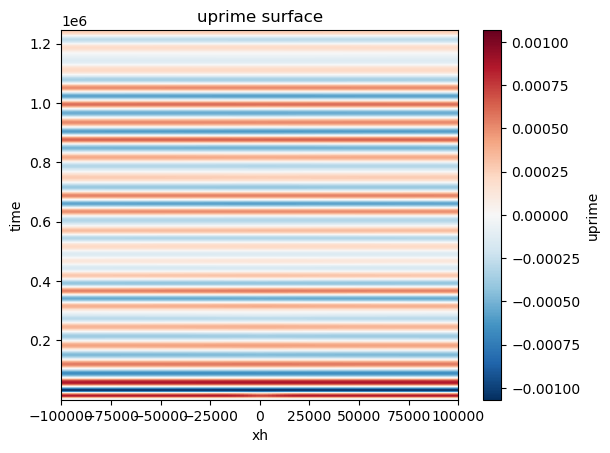

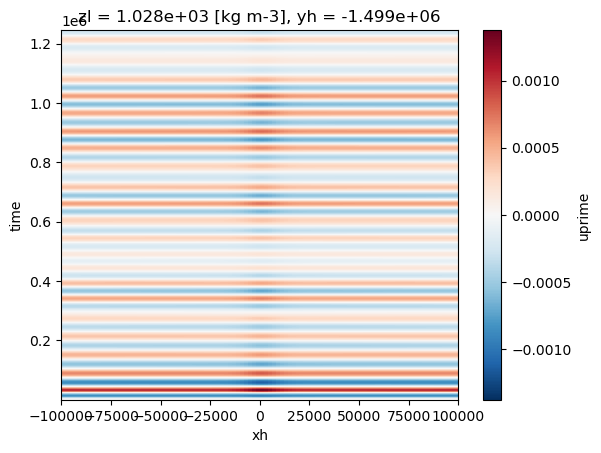

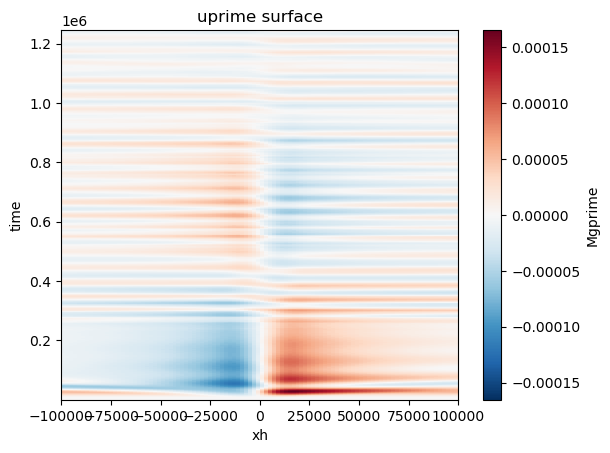

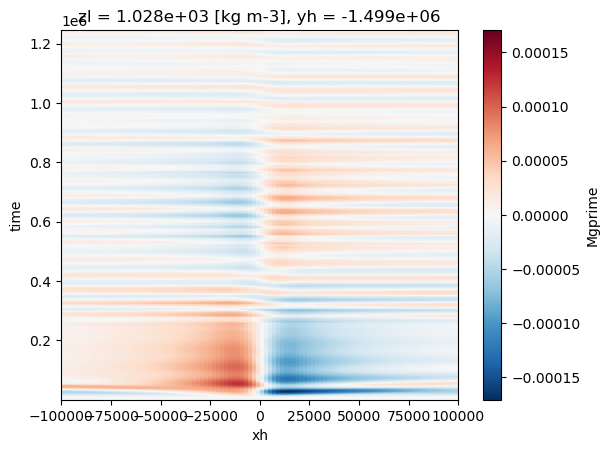

<Figure size 640x480 with 0 Axes>

In [36]:
out.uprime.isel(yh = 5,zl = 0).plot()
plt.title("uprime surface")
plt.figure()
out.uprime.isel(yh = 5,zl = 1).plot()
plt.figure()
out.Mgprime.isel(yh = 5,zl = 0).plot()
plt.title("uprime surface")
plt.figure()
out.Mgprime.isel(yh = 5,zl = 1).plot()
plt.figure()

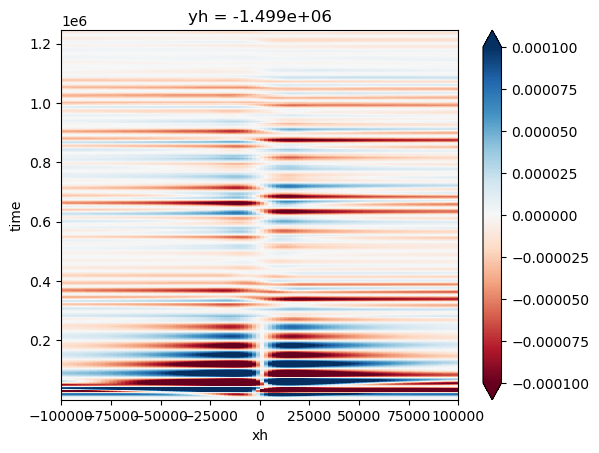

In [45]:
(out.Mgprime * out.uprime * out.thickness).sum("zl").isel(yh = 5).plot(vmin = -0.0001,vmax = 0.0001,cmap = "RdBu")

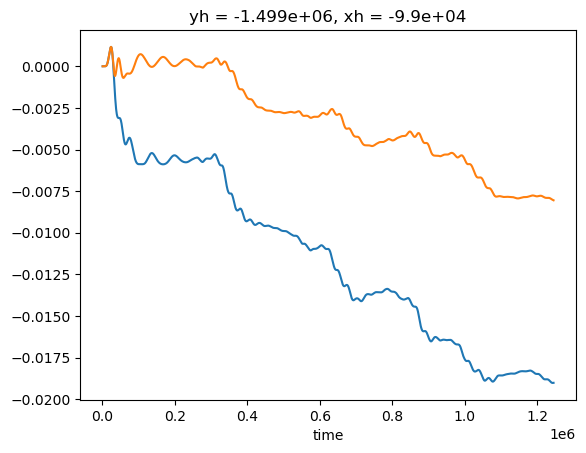

In [50]:
(out.Mgprime * out.uprime * out.thickness).sum("zl").isel(yh = 5,xh = -1).cumsum("time").plot()

(out.Mgprime * out.uprime * out.thickness).sum("zl").isel(yh = 5,xh = 0).cumsum("time").plot()



In [2]:
common_wind = xr.open_dataset("/home/149/ab8992/bottom_near_inertial_waves/juneruns/june_height_ridge_5layer/tests/modifystrength1/work/INPUT/storm_windstress.nc")
workingwind = xr.open_dataset("/home/149/ab8992/bottom_near_inertial_waves/juneruns/june_height_ridge_5layer/tests/fromstrength1/work/INPUT/storm_windstress.nc")

In [3]:
common_wind

<xarray.Dataset>
Dimensions:   (x: 2000, y: 500, Time: 1)
Coordinates:
  * x         (x) float64 0.0 2.0 4.0 6.0 ... 3.994e+03 3.996e+03 3.998e+03
  * y         (y) float64 -500.0 -498.0 -496.0 -494.0 ... 494.0 496.0 498.0
  * Time      (Time) float64 300.0
Data variables:
    STRESS_X  (Time, y, x) float64 ...
    STRESS_Y  (Time, y, x) float64 ...

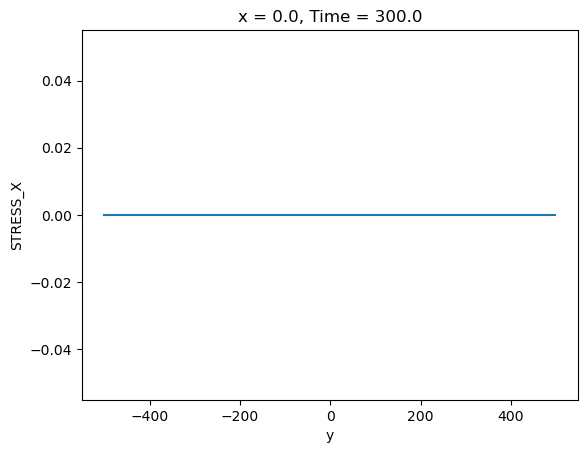

In [7]:
workingwind.STRESS_X[:,:,0].plot()